In [11]:
import torch
import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import numpy as np
import matplotlib.pyplot as plt

from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# PYRO
[Getting started page](https://pyro.ai/examples/index.html)

## Stochastic Variational Inference

You’ve been given a two-sided coin. You want to determine whether the coin is fair or not, i.e. whether it falls heads or tails with the same frequency. It’s a bit banged up from years of use, so while you expect the coin to have been quite fair when it was first produced, you allow for its fairness to have since deviated from a perfect 1:1 ratio.

To turn this into a probabilistic model we encode heads and tails as 1s and 0s. We encode the fairness of the coin as a real number $f$, where $f\in[0,1]$ and $f=0.5$ corresponds to a perfectly fair coin. Our prior belief about $f$ will be encoded by a Beta distribution, specifically $\text{Beta}(10,10)$, which is a symmetric probability distribution on the interval $[0,1]$ that is peaked at $f=0.5$.

### Data
Data $x$:

In [ ]:
# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))
data = torch.tensor(data)


### Model

Given some observations $x$, latent RV $z$, and paramenter $\theta$, the link between them is called (probabilistic) **model**, with pdf $$p_\theta(x,z)=p_\theta(x|z)p_\theta(z)$$
where $p_\theta(x|z)$ is the *likelihood*, $p_\theta(z)$ is the *prior*.

Things that we may be interested in are:
- inferring something about $z$ from data, i.e., the *posterior* $p_\theta(z|x)=\frac{p_\theta(x,z)}{\int dz p_\theta(x,z)}$
- how well the model describes data, i.e., the *marginal* $p_\theta(x)=\int dz p_\theta(x,z)$
- predict new data from the *posterior predictive distribution* $p_\theta(x'|x)=\int dz p_\theta(x'|z)p_\theta(z|x)$
- learning the parameter $\theta$ that best explain data, $\theta_\text{max}=\argmax_\theta p_\theta(x)$

Below we define a model according to our assumptions:
- the prior is a Beta
- the likelihood is a Bernoulli

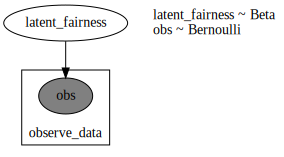

In [3]:
def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # vectorized plate over the observed data
    with pyro.plate('observe_data'):
        # likelihood Bernoulli(f)
        pyro.sample('obs', dist.Bernoulli(f), obs=data)

pyro.render_model(model, model_args=(data,), render_distributions=True)

Using plate tells Pyro that the observations are indipendent (conditioned on the latent variable), but it also allow to do subsampling. Notice that if data is on GPU, you should pass a "device" argument to plate.

### Guide
A **guide** is the variational distribution $q_\phi(z)$ that approximates the posterior $p_\theta(z|x)$. It does not contain data, unlike the model, but it must have all the latent variables that the model has. The correspondence is guaranteed by their **names**(more on this later).

In [4]:
def guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

Notice that the guide above doesn't have the "obs" RV, but it could have a "plate" in more complex scenarios.

### Inference step
In order to do variational inference PYRO uses SVI class, which needs: a model, a guide and an optimizer.

In [5]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
losses = []
# do gradient steps
for step in range(n_steps):
    loss = svi.step(data) # step ensures that data is passed to both model and guide
    losses.append(loss)

    if step % 500 == 0:
        print(f"Loss: {loss}")

Loss: 7.212564945220947
Loss: 7.019371032714844
Loss: 7.07565450668335
Loss: 7.0810346603393555
Loss: 7.252779960632324
Loss: 7.048000335693359
Loss: 7.064761161804199
Loss: 7.075110912322998
Loss: 7.079219341278076
Loss: 7.058321952819824


What did we learn?

In [6]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.533 +- 0.090


In this simple scenario we can analytically compute the true posterior using Bayes' theorem:
- The latent variable $z$ is defined within the model and its prior is a Beta distribution, i.e., $$p(z;\alpha,\beta)=\frac{1}{B(\alpha,\beta)}z^{\alpha-1}(1-z)^{\beta-1},$$ where $B(\alpha,\beta)$ is the normalizing factor.
- The likelihood is defined within the model as well and it's a Bernoulli, $p(x|z)=z^x(1-z)^{1-x}$.

So the true posterior is 
$$
\begin{align}
    p(z|x) &\propto \prod_{i=1}^N \, p(z;\alpha,\beta)p(x_i|z) \propto \\
        &\propto \prod_i \, z^{\alpha-1}(1-z)^{\beta-1}z^x_i(1-z)^{1-x_i} = \\
        &= z^{\alpha-1+\sum_i x_i}(1-z)^{N+\beta-1-\sum_i x_i} 
\end{align}
$$
which is again a Beta distribution (so our guide is not an _approximation_ of the true distribution, that explains why the loss doesn't really decrease much) with coefficients
$$
    \tilde{\alpha} = \alpha +\sum_{i=1}^N\,x_i = 10 + 6 = 16
$$
$$
    \tilde{\beta} = N + \beta - \sum_{i=1}^N\,x_i = 10 + 10 - 6 = 14
$$
($\sum_i\,x_i=6$ since we have 6 heads and 4 tails), which give
$$
    \text{mean} = \frac{\tilde{\alpha}}{\tilde{\alpha}+\tilde{\beta}} = \frac{16}{30} = 0.5\bar{3}
$$
$$
    \text{std} = \frac{1}{\tilde{\alpha}+\tilde{\beta}}\sqrt{\frac{\tilde{\alpha}\tilde{\beta}}{\tilde{\alpha}+\tilde{\beta}+1}} \simeq 0.09
$$
They are compatible with what found with SVI
$$
    \lambda = \frac{|0.5\bar{3}-0.537|}{\sqrt{0.089^2+0.09^2}} \simeq 0.03 < 1.
$$

In [8]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

alpha_q 16.012342
beta_q 14.004918


Let's sample more data using our newly found approximate posterior

In [10]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100)
svi_samples = predictive(data = None)
sampled_data = svi_samples['obs']

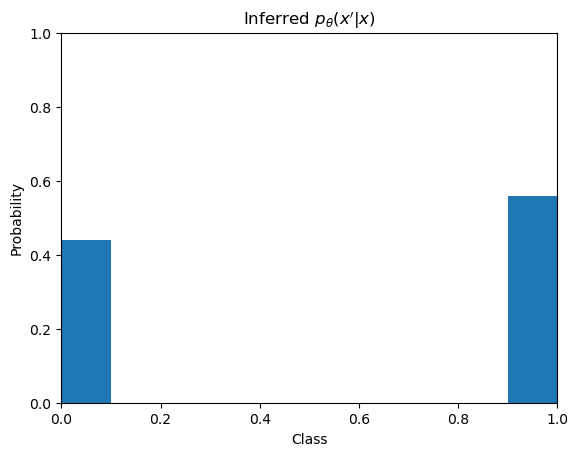

In [27]:
plt.bar(np.unique(sampled_data, return_counts=True)[0],
        np.unique(sampled_data, return_counts=True)[1]/np.sum(np.unique(sampled_data, return_counts=True)[1]),
        width=0.2)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(r"Inferred $p_\theta(x'|x)$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## WARNING: parameters' names
Parameters' names are global, so they can be shared between different models/guides and cause issues.


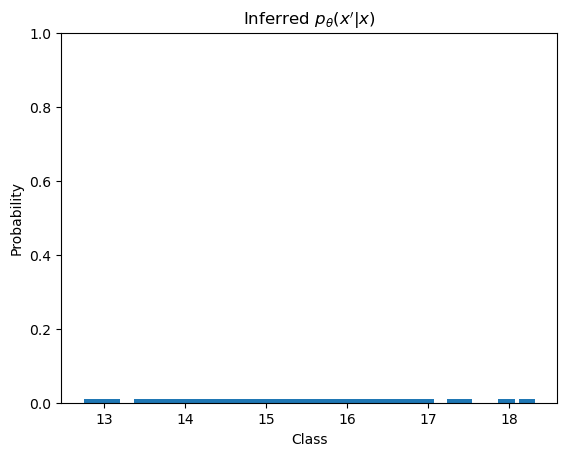

In [35]:
def model2(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(0.0)
    beta0 = torch.tensor(1.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Uniform(alpha0, beta0))
    # vectorized plate over the observed data
    with pyro.plate('observe_data'):
        # likelihood Bernoulli(f)
        pyro.sample('obs', dist.Normal(f,1), obs=data)

def guide2(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Uniform(beta_q, alpha_q))

predictive2 = pyro.infer.Predictive(model2, guide=guide2, num_samples=100)
svi_samples2 = predictive2(data = None)
sampled_data2 = svi_samples2['obs']

plt.bar(np.unique(sampled_data2, return_counts=True)[0],
        np.unique(sampled_data2, return_counts=True)[1]/np.sum(np.unique(sampled_data2, return_counts=True)[1]),
        width=0.2)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(r"Inferred $p_\theta(x'|x)$")
# plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [36]:
(sampled_data==sampled_data2).all()

tensor(False)

In [30]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

alpha_q 16.012342
beta_q 14.004918
